In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

import os
import glob
import re
from scanf import scanf
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from matplotlib import cm

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf

# %matplotlib notebook

rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

In [2]:
def read_data_psi(psi_dir, tcenter):
    ecoli_U_list = []
    ecoli_norm_list = []
    ecoli_center_list = []
    ecoli_nodes_list = []
    ecoli_u_list = []
    ecoli_f_list = []
    ecoli_lateral_norm_list = []
    norm_phi_list = []
    norm_psi_list = []
    norm_theta_list = []
    file_handle = os.path.basename(psi_dir)
    mat_names = natsort.natsorted(glob.glob('%s/%s_*.mat' % (psi_dir, file_handle)))
    for mati in mat_names:
        mat_contents = loadmat(mati)
        ecoli_U = mat_contents['ecoli_U'].flatten()
        ecoli_norm = mat_contents['ecoli_norm'].flatten()
        ecoli_center = mat_contents['ecoli_center'].flatten()
        ecoli_nodes = mat_contents['ecoli_nodes']        
        ecoli_u = mat_contents['ecoli_u']
        ecoli_f = mat_contents['ecoli_f']
        planeShearRate = mat_contents['planeShearRate'].flatten()
        norm_phi = mat_contents['norm_phi'].flatten()
        norm_psi = np.nan
        norm_theta = mat_contents['norm_theta'].flatten()
        
        #dbg 
        t_max = np.max(ecoli_nodes, axis=0)
        t_min = np.min(ecoli_nodes, axis=0)
        ecoli_center = (t_max - t_min) / 2 + t_min
        ecoli_U = ecoli_U - np.hstack((planeShearRate[0] * ecoli_center[2], np.zeros(5)))
        
        ecoli_U_list.append(ecoli_U)
        ecoli_norm_list.append(ecoli_norm)
        ecoli_center_list.append(ecoli_center)
        norm_phi_list.append(norm_phi)
        norm_psi_list.append(norm_psi)
        norm_theta_list.append(norm_theta)
        r0 = ecoli_nodes[-1] - ecoli_center
        n0 = np.dot(r0, ecoli_norm) * ecoli_norm / np.dot(ecoli_norm, ecoli_norm)
        t0 = r0 - n0
        ecoli_lateral_norm_list.append(t0 / np.linalg.norm(t0))
        # dbg
        ecoli_nodes_list.append(ecoli_nodes)
        
    ecoli_U = np.vstack(ecoli_U_list)
    ecoli_norm = np.vstack(ecoli_norm_list)
    ecoli_center = np.vstack(ecoli_center_list)
    ecoli_lateral_norm = np.vstack(ecoli_lateral_norm_list)
    norm_phi = np.hstack(norm_phi_list)
    norm_psi = np.hstack(norm_psi_list)
    norm_theta = np.hstack(norm_theta_list)
    norm_tpp = np.vstack((norm_theta, norm_phi, norm_psi)).T

    # calculate velocity u000(t,x,y,z) that the location initially at (0, 0, 0): u000(0, 0, 0, 0)
    n_u000 = -np.linalg.norm(ecoli_center[0] - tcenter) * ecoli_norm
    ecoli_u000 = ecoli_U[:, :3] + np.cross(ecoli_U[:, 3:], n_u000)
    # calculate center center000(t,x,y,z) that at initially at (0, 0, 0): center000(0, 0, 0, 0)
    ecoli_center000 = ecoli_center + n_u000
    using_U = ecoli_U
    omega_norm = np.array([np.dot(t1, t2)*t2/np.dot(t2, t2) for t1, t2 in zip(using_U[:, 3:], ecoli_norm)])
    omega_tang = using_U[:, 3:] - omega_norm
    
    return ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, norm_tpp, \
           ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate, file_handle, \
           ecoli_nodes_list

-1.15106971967e-05 7.38583869444e-05
-4.32194365368e-05 4.32133601218e-05
-7.38395497617e-05 7.38395540776e-05
-0.199755591885 0.199755520397


/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


0.100460992245 0.900037481766
-0.199943433302 0.199942311532


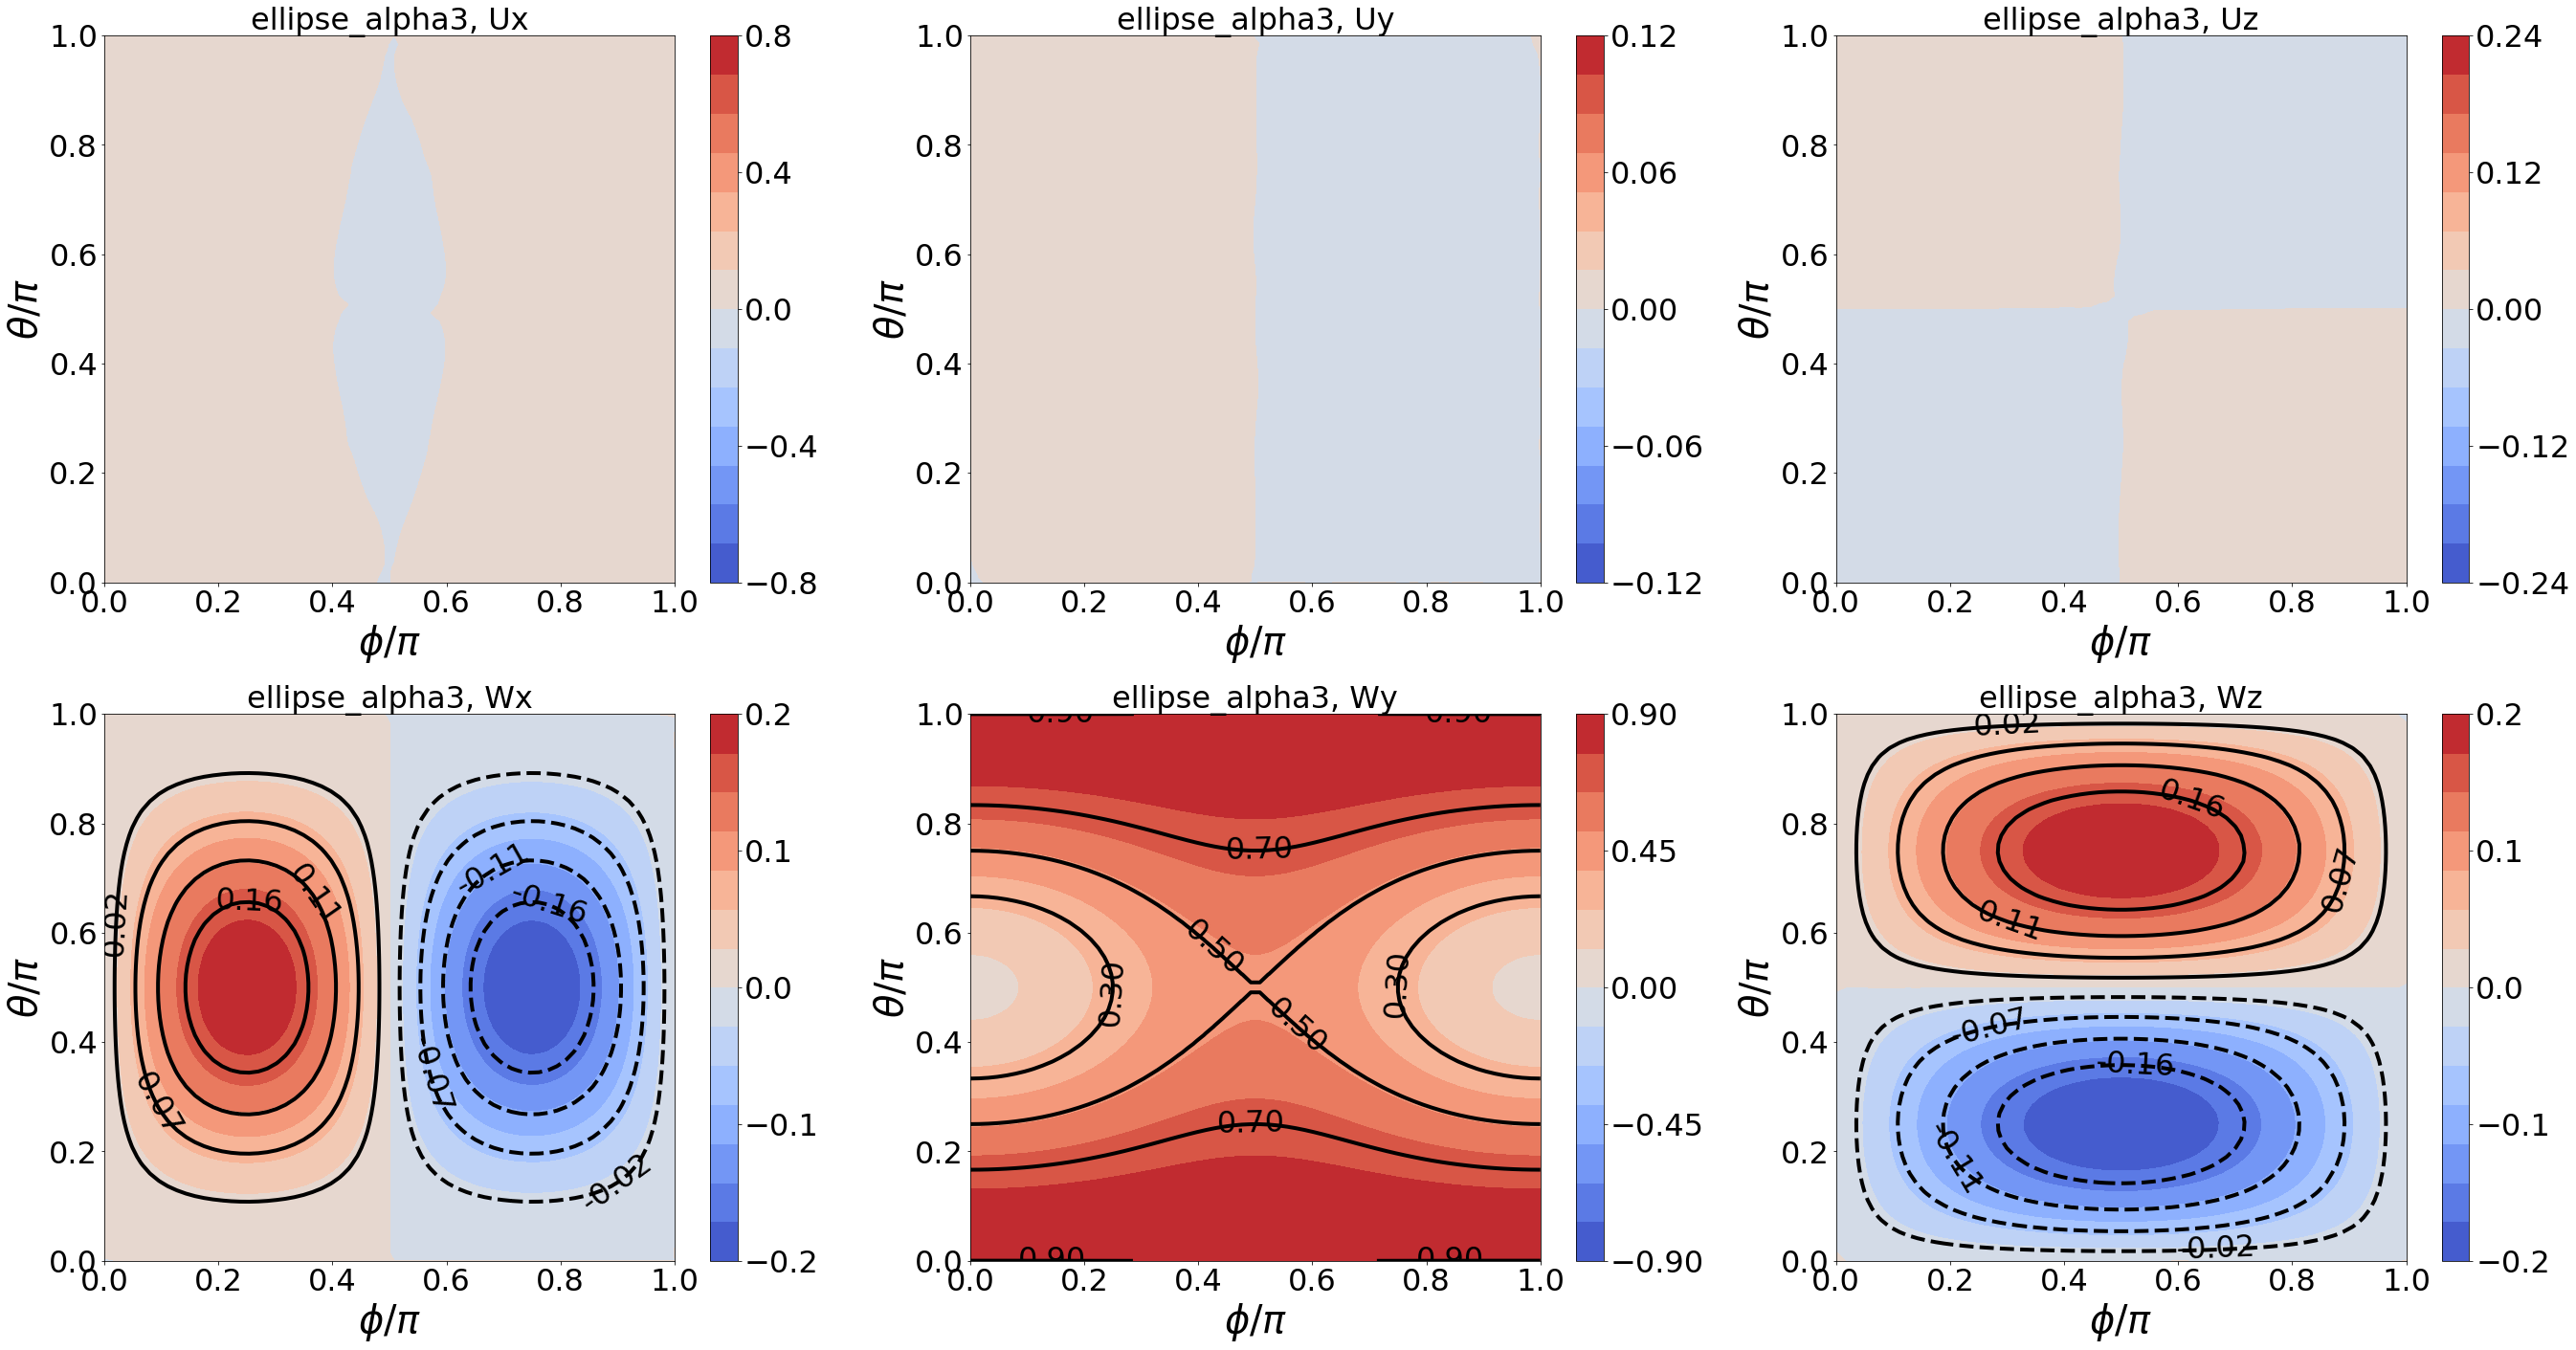

In [3]:
# %matplotlib notebook
%matplotlib inline

importlib.reload(spf)
psi_dir = '/home/zhangji/stokes_flow_master/head_Force/loop_table/ellipse_alpha3'
tcenter = np.zeros(3)

ecoli_U, ecoli_norm, ecoli_center, ecoli_lateral_norm, norm_tpp, \
  ecoli_u000, ecoli_center000, omega_norm, omega_tang, planeShearRate, file_handle, \
  ecoli_nodes_list \
  = read_data_psi(psi_dir, tcenter)
norm_theta = norm_tpp[:, 0]
norm_phi = norm_tpp[:, 1]
norm_psi = norm_tpp[:, 2]
data = pd.DataFrame({'norm_theta': norm_theta, 
                    'norm_phi': norm_phi, 
                    'norm_psi': norm_phi * 0, 
                    'ecoli_U0': ecoli_U[:, 0], 
                    'ecoli_U1': ecoli_U[:, 1], 
                    'ecoli_U2': ecoli_U[:, 2], 
                    'ecoli_U3': ecoli_U[:, 3], 
                    'ecoli_U4': ecoli_U[:, 4], 
                    'ecoli_U5': ecoli_U[:, 5], 
                    }).pivot_table(index=['norm_theta', 'norm_phi', 'norm_psi'])
norm_tpp = np.vstack(data.index.get_values())
norm_theta = norm_tpp[:, 0]
norm_phi = norm_tpp[:, 1]
norm_psi = norm_tpp[:, 2]
use_theta = np.unique(norm_theta)
use_phi = np.unique(norm_phi)
use_psi = np.unique(norm_psi)
n_theat, n_phi, n_psi = use_theta.size, use_phi.size, use_psi.size

fig = plt.figure(figsize=(38, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(2, 3, 1)
ax1 = fig.add_subplot(2, 3, 2)
ax2 = fig.add_subplot(2, 3, 3)
ax3 = fig.add_subplot(2, 3, 4)
ax4 = fig.add_subplot(2, 3, 5)
ax5 = fig.add_subplot(2, 3, 6)
for axi, ui, zlabeli, (vmin, vmax) in zip((ax0, ax1, ax2, ax3, ax4, ax5), 
                                            ecoli_U.T, 
                                            ('Ux', 'Uy', 'Uz', 'Wx', 'Wy', 'Wz'), 
                                            ((-0.8, 0.8), (-0.12, 0.12), (-0.24, 0.24), 
                                             (-0.2, 0.2), (-0.9, 0.9), (-0.2, 0.2))):
    print(ui.min(), ui.max())
    plt.sca(axi)
    ticks = np.linspace(vmin, vmax, 15)
    im = axi.contourf(norm_tpp[:, 1].reshape((n_theat, n_phi)) / np.pi, 
                      norm_tpp[:, 0].reshape((n_theat, n_phi)) / np.pi, 
                      ui.reshape((n_theat, n_phi)), ticks, 
                      cmap=cm.coolwarm)
    ticks = np.linspace(vmin, vmax, 5)
    fig.colorbar(im, ticks=ticks, ax=axi).ax.tick_params(labelsize=fontsize*0.8)
    ticks = np.linspace(vmin, vmax, 10)
    im = axi.contour(norm_tpp[:, 1].reshape((n_theat, n_phi)) / np.pi, 
                     norm_tpp[:, 0].reshape((n_theat, n_phi)) / np.pi, 
                     ui.reshape((n_theat, n_phi)), ticks, 
                      linewidths=fontsize*0.1, colors='k')
    plt.clabel(im, fmt='%4.2f', colors='k', fontsize=fontsize*0.8, inline=0, rightside_up=1)
    axi.set_xlabel('$\\phi / \pi$', size=fontsize)
    axi.set_ylabel('$\\theta / \pi$', size=fontsize)
    axi.set_title('%s, %s' % (file_handle, zlabeli), size=fontsize*0.8)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

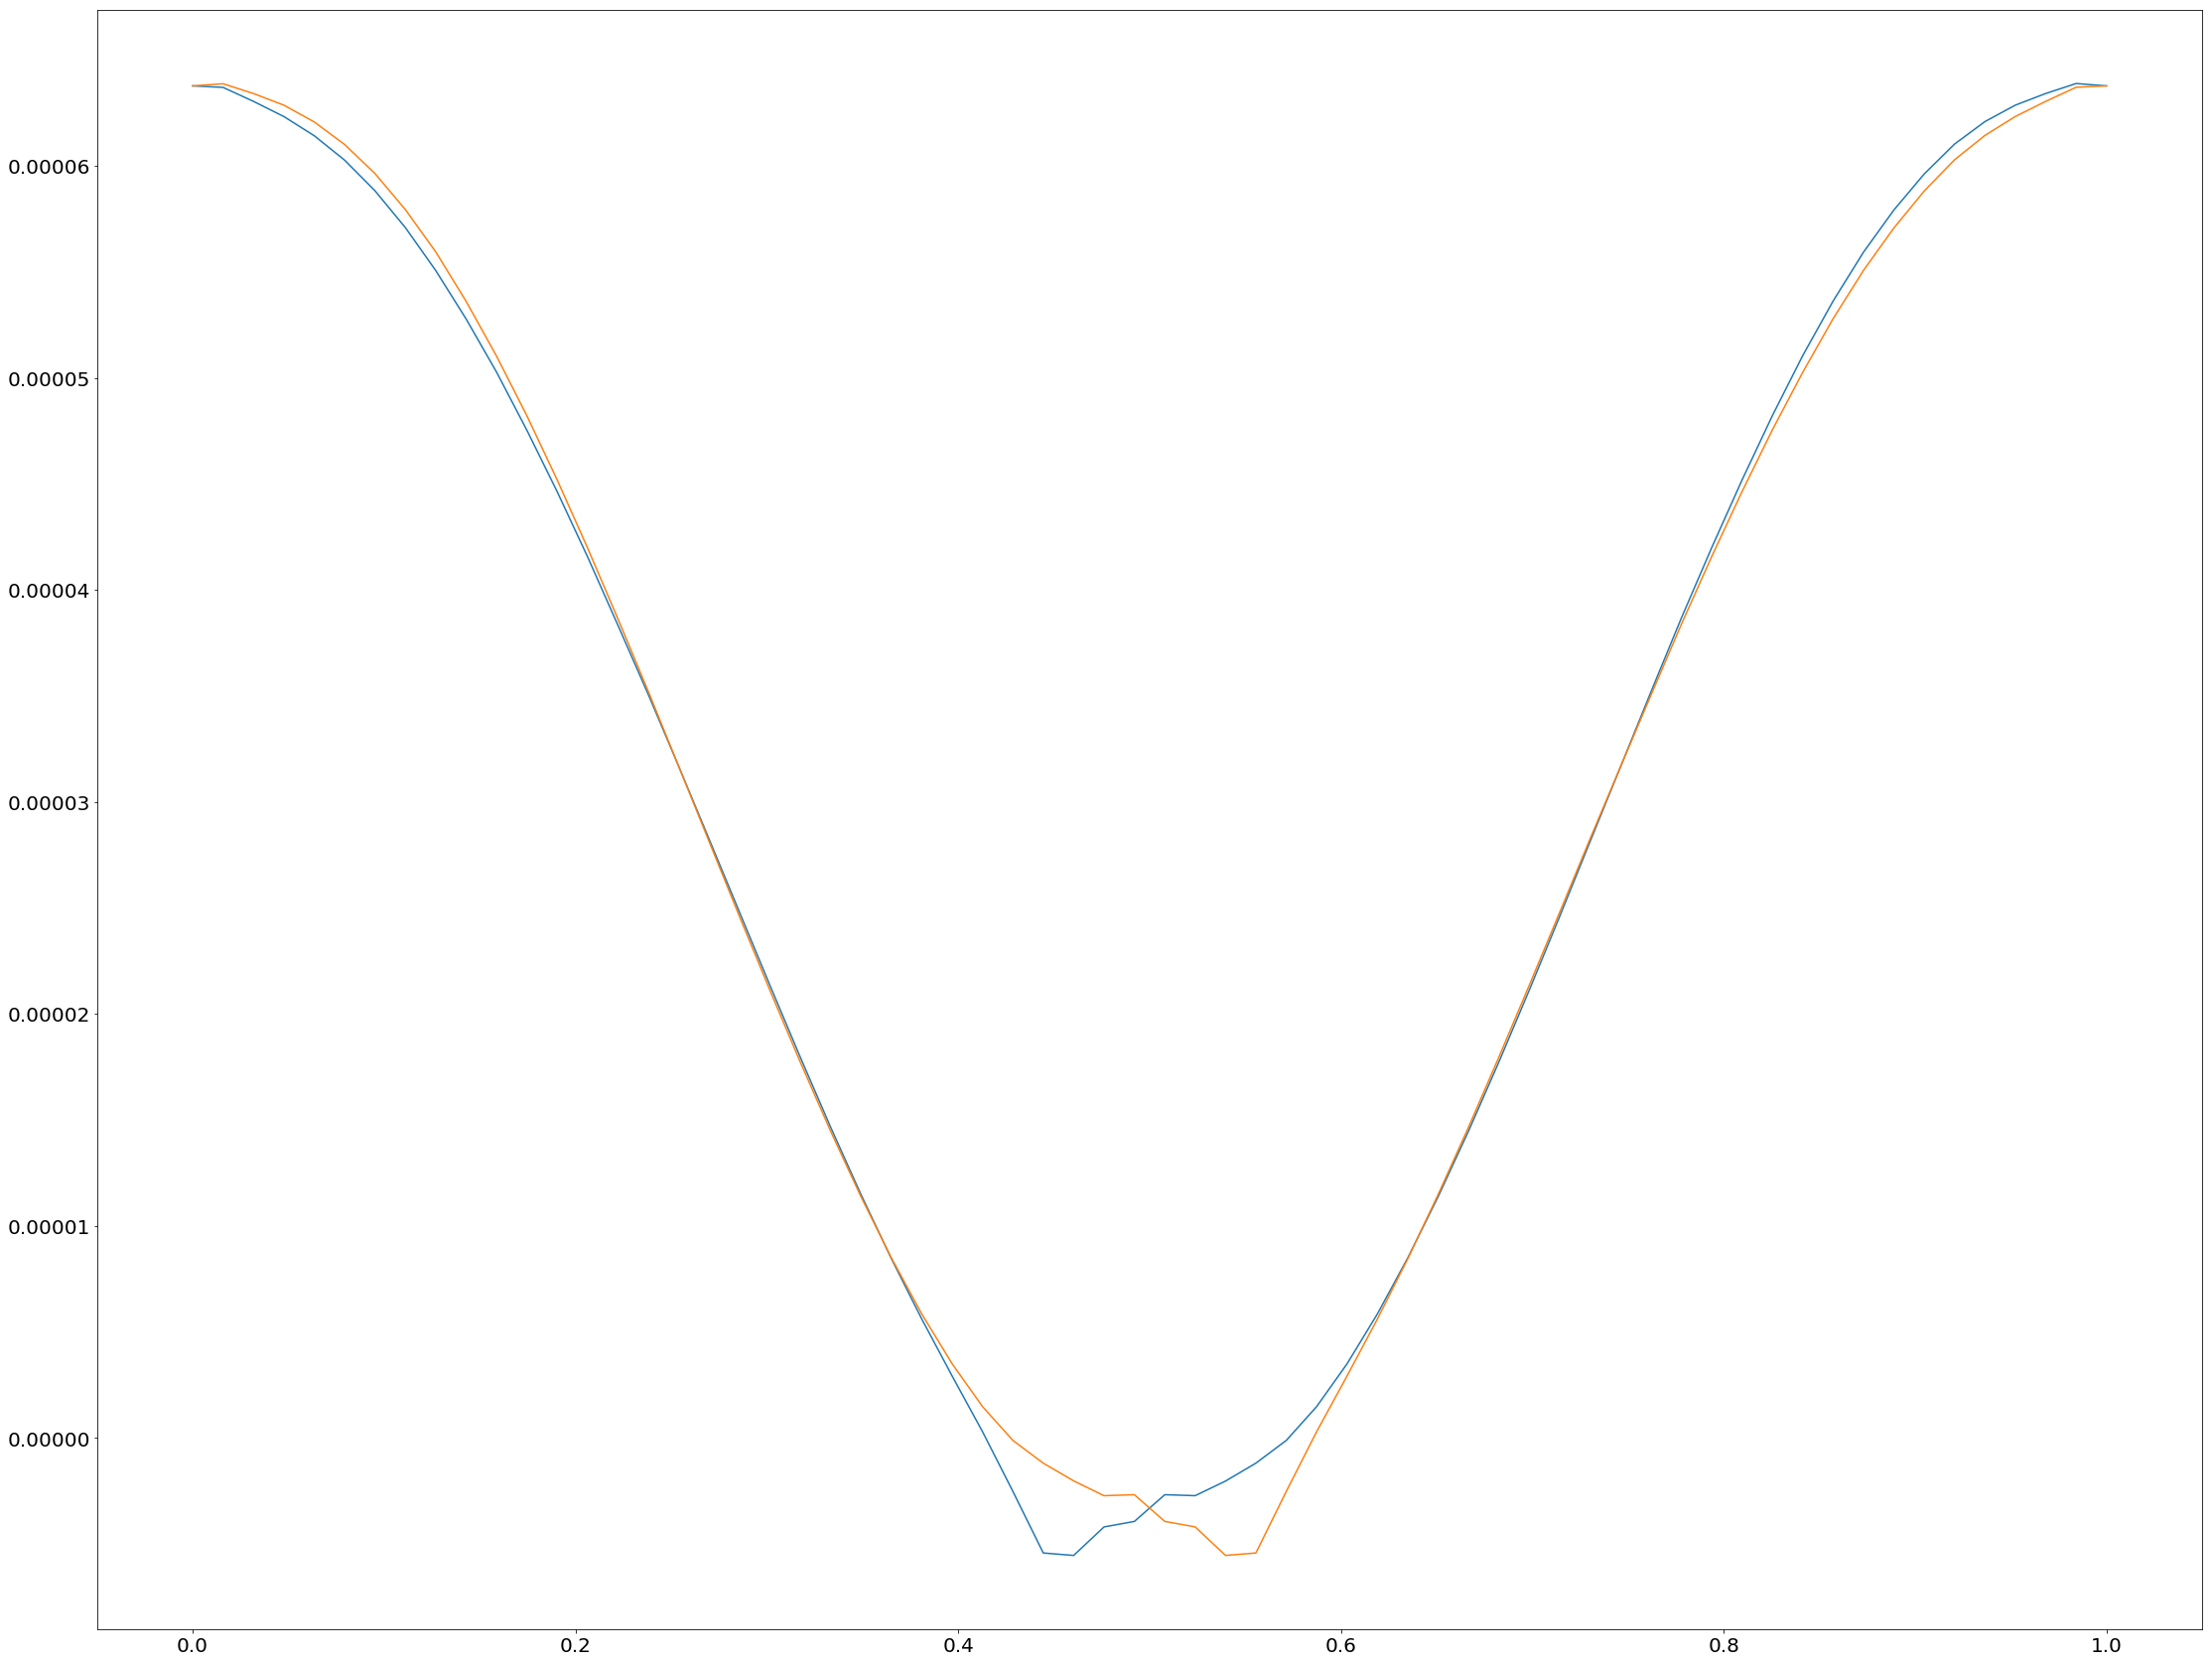

In [4]:
# plot(uz(theta==0, phi))
fig = plt.figure(figsize=(38, 30))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)
tx = norm_tpp[:, 1].reshape((n_theat, n_phi))[31:33].T / np.pi # phi
ty = ecoli_U[:, 0].reshape((n_theat, n_phi))[31:33].T  # uz
ax0.plot(tx, ty)

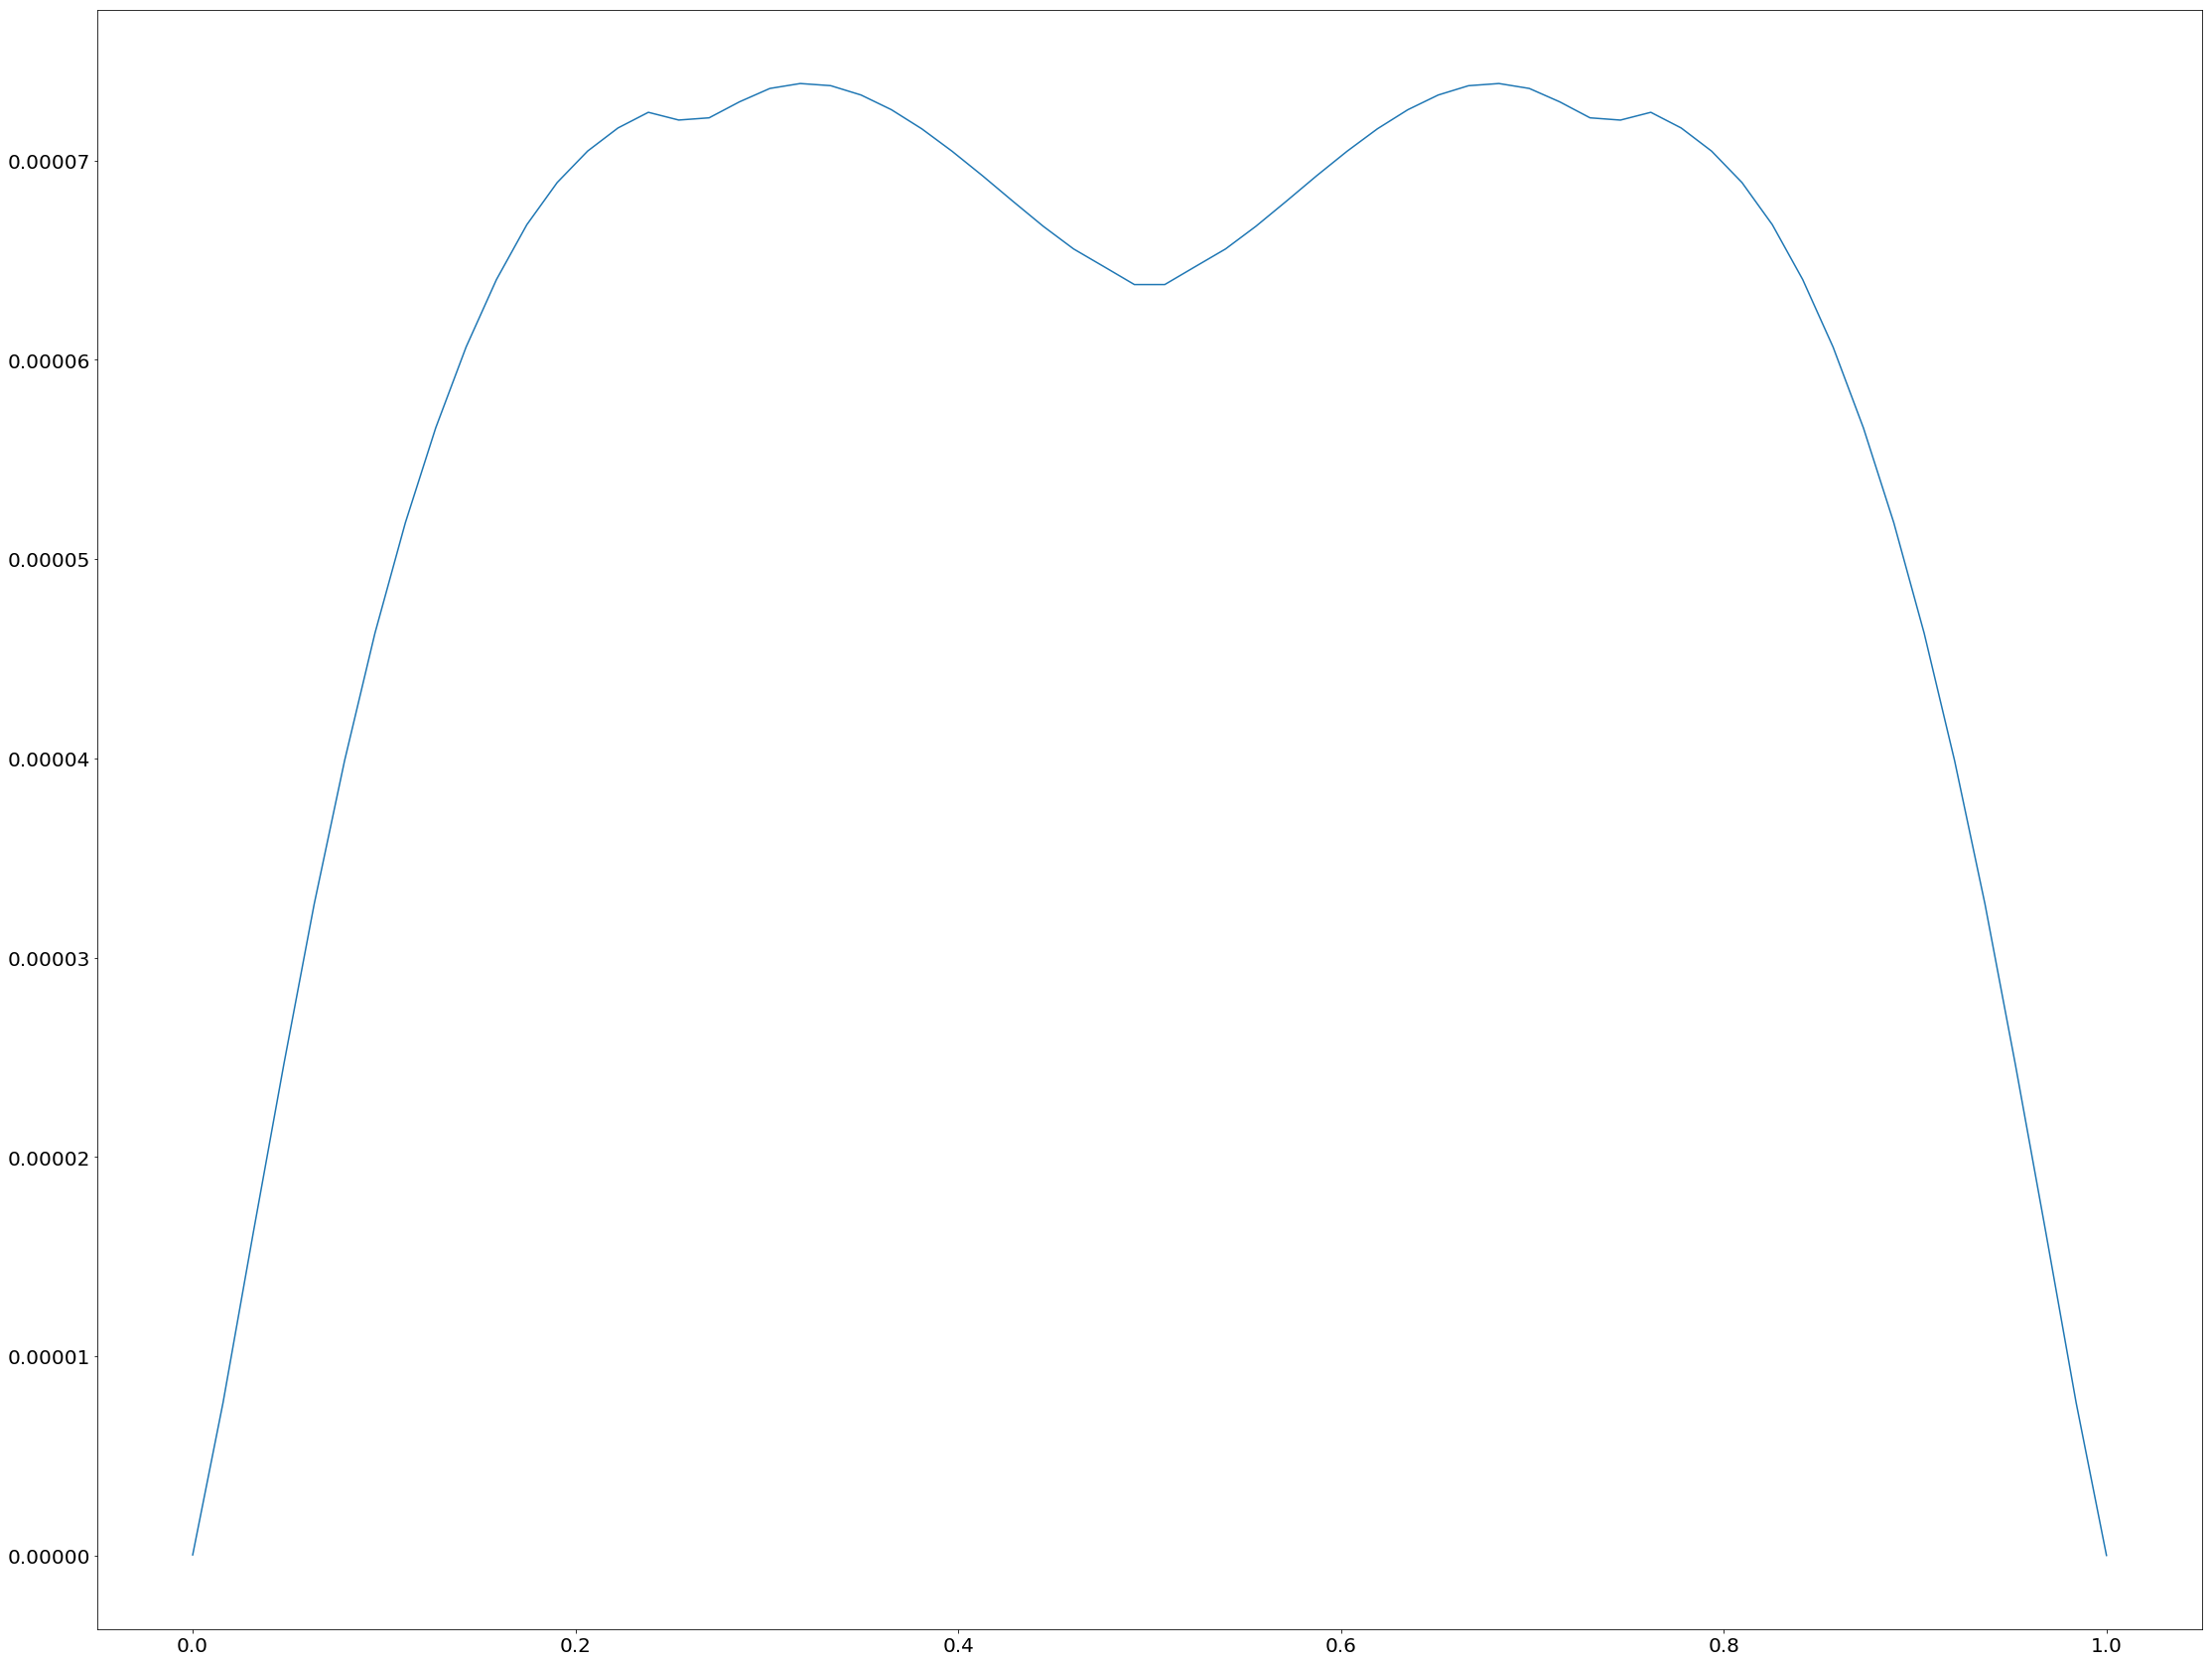

In [6]:
# plot(uz(theta, phi==0))
fig = plt.figure(figsize=(38, 30))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)
tx = norm_tpp[:, 0].reshape((n_theat, n_phi))[:, 0].T / np.pi # phi
ty = ecoli_U[:, 0].reshape((n_theat, n_phi))[:, 0].T  # ux
ax0.plot(tx, ty)

In [7]:
table_data = []
intp_fun_list = []
for tpsi in np.linspace(0, 2*np.pi, 5, endpoint=False): # interpolate over 1d, psi, for ellipse case psi is fake, and it just copy the data. 
    tintp_fun_list = []
    table_psi_data = []
    for t1 in data.columns.values: # interpolate fun for [ux,uy,uz,wx,wy,wz]
        tu = data[t1].unstack()
        tU = tu[0].unstack()
        tU = tU.interpolate(method='quadratic',axis=1).interpolate(method='quadratic',axis=0)
        tx = tU.columns.values # norm_phi
        ty = tU.index.values # norm_theta
        # interpolate over 2d
        tfun = interpolate.RectBivariateSpline(ty, tx, tU)
        tintp_fun_list.append(tfun)
        table_psi_data.append((ty, tx, tU))
    table_data.append((tpsi, table_psi_data))
    intp_fun_list.append(tintp_fun_list)
    
import pickle
filename = 'ellipse_alpha3'
with open('%s.pickle' % filename, 'wb') as handle:
    pickle.dump(table_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('save table_data to %s.pickle' % filename)
    
with open('%s.pickle' % filename, 'rb') as handle:
    table_data = pickle.load(handle)

intp_fun_list = []
for tpsi, table_psi_data in table_data:
    tintp_fun_list = []
    for ty, tx, tU in table_psi_data:
        tfun = interpolate.RectBivariateSpline(ty, tx, tU)
        tintp_fun_list.append(tfun)
    intp_fun_list.append(tintp_fun_list)


save table_data to ellipse_alpha3.pickle


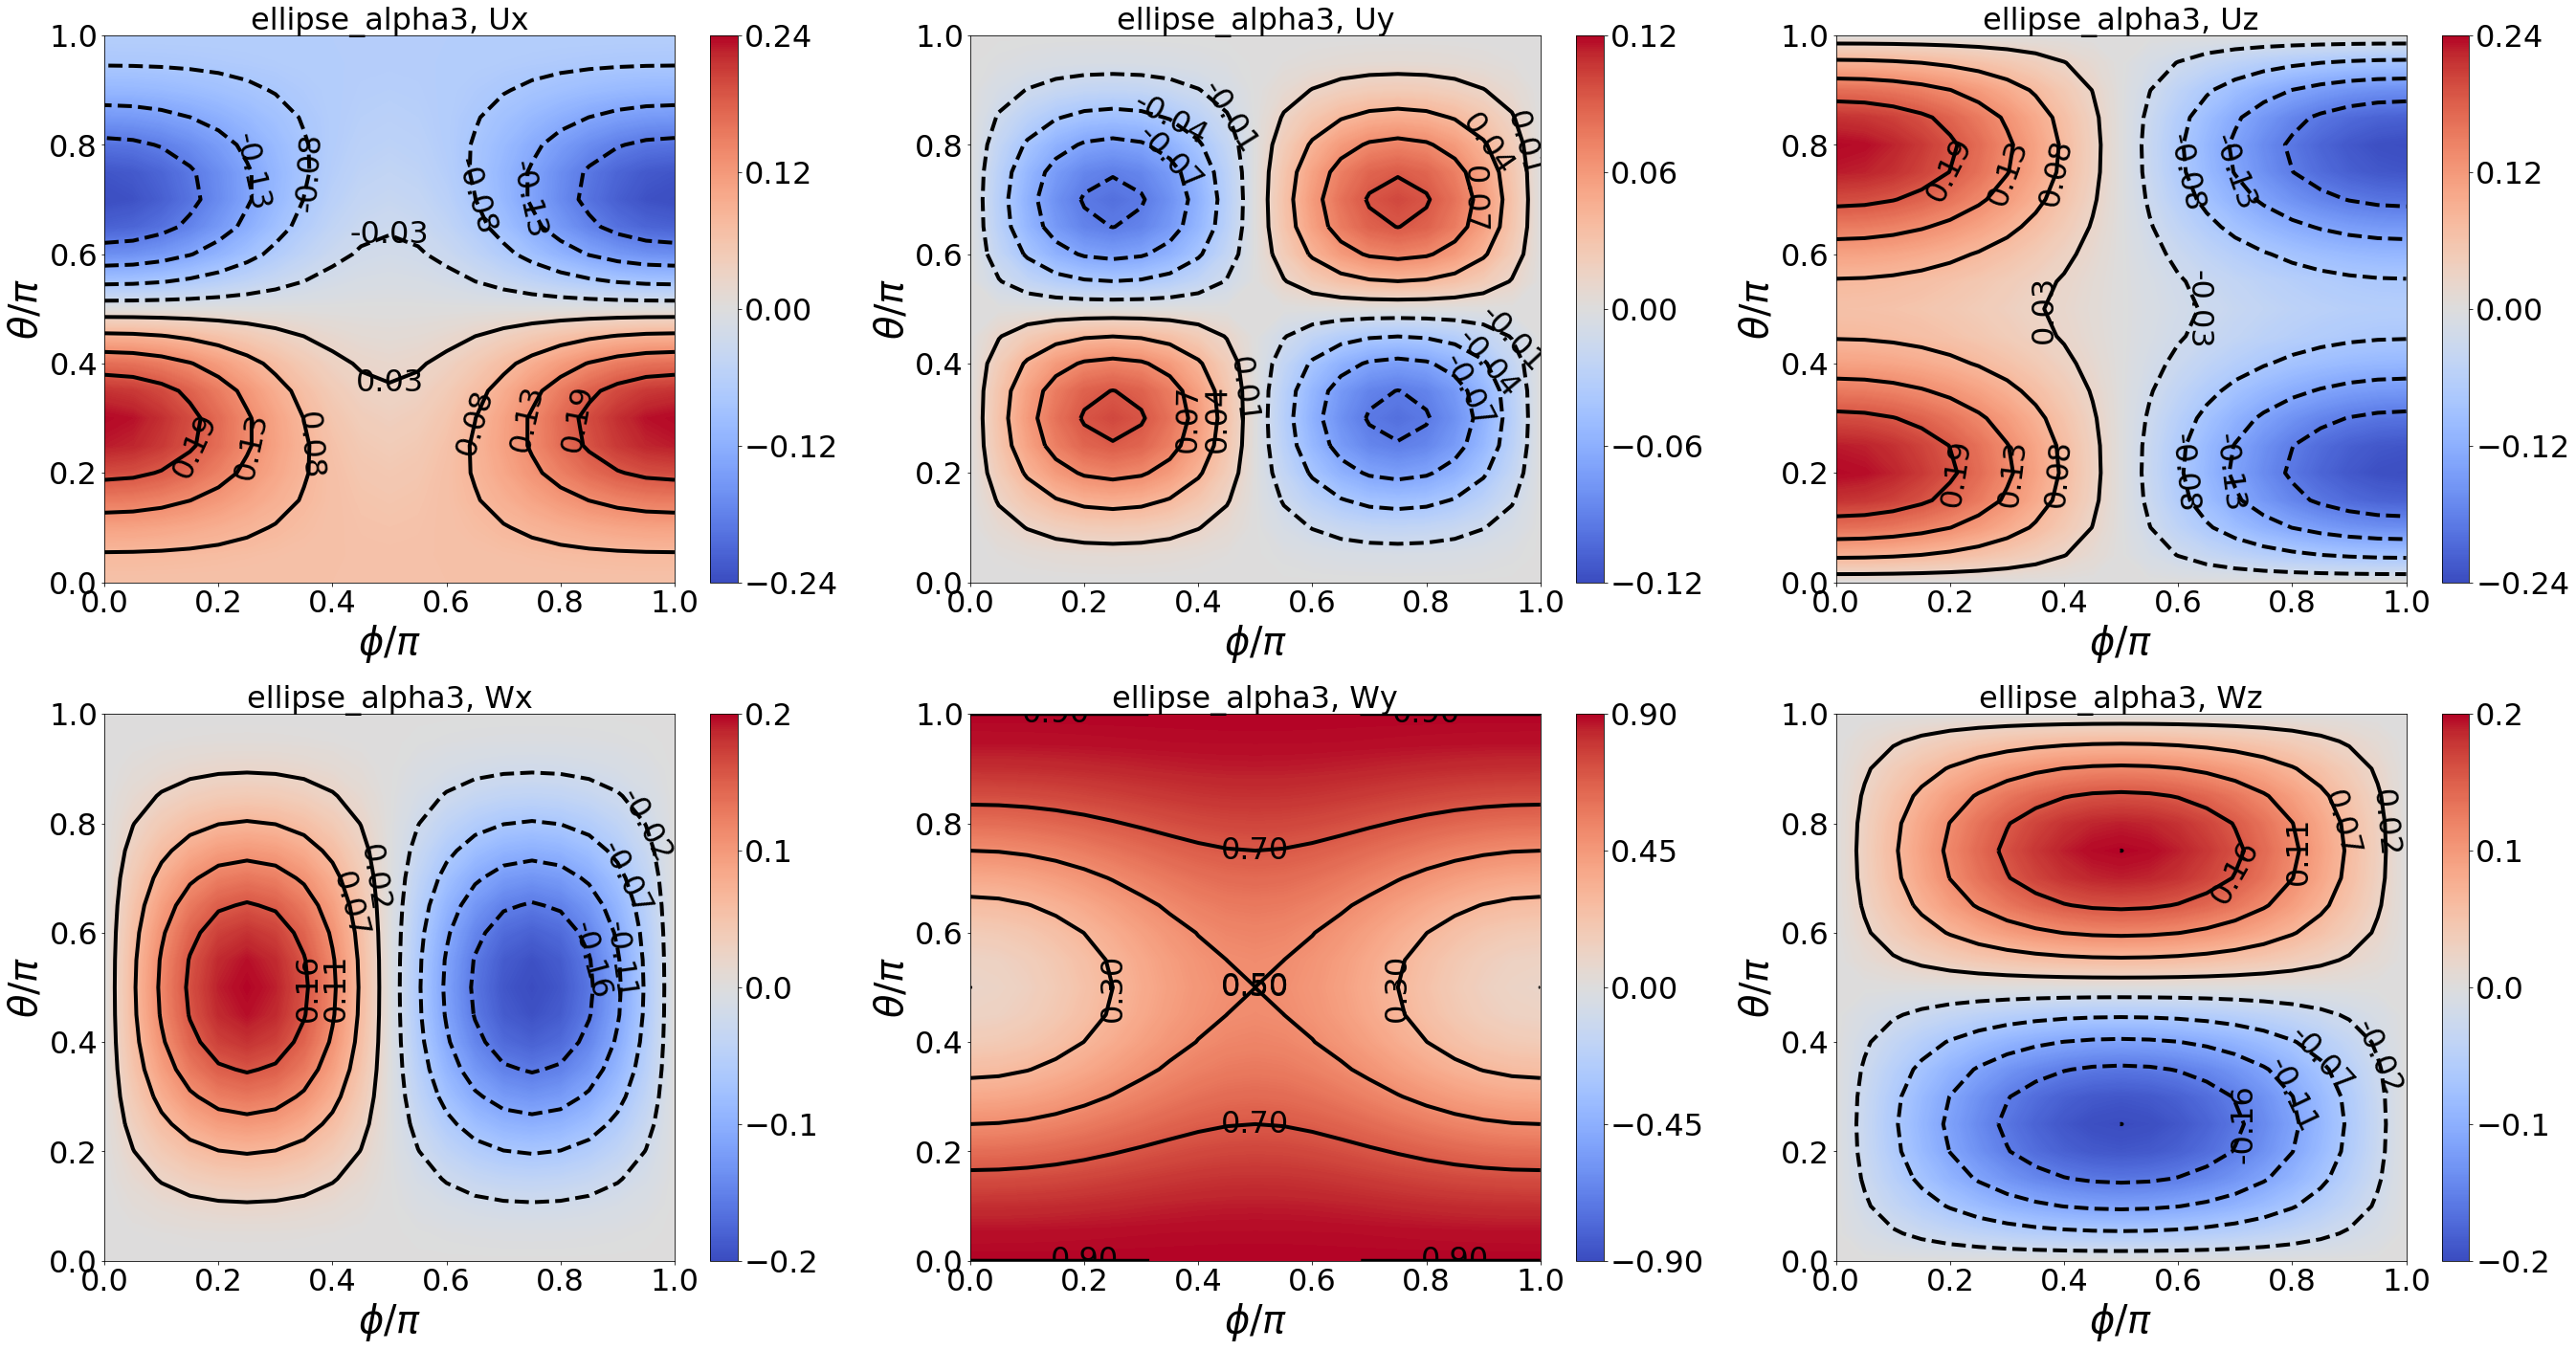

In [10]:
# contour plot for the table result 

importlib.reload(jm)
eval_dt = 0.1
max_iter = 300
update_order = 3
ellipse_speed = 0
planeShearRate = np.array((1, 0, 0))
talpha = 1 / 0.3
tnorm = np.array((1, 0, 0))
lateral_norm = np.array((0, 1, 0))
tcenter = np.array((0, 0, 0))

# Table result
ellipse_kwargs = {'name':         'ellipse',
                  'center':       tcenter,
                  'norm':         tnorm / np.linalg.norm(tnorm),
                  'lateral_norm': lateral_norm / np.linalg.norm(lateral_norm),
                  'speed':        ellipse_speed,
                  'lbd':          (talpha ** 2 - 1) / (talpha ** 2 + 1), 
                  'table_name':   'ellipse_alpha3', }
fileHandle = 'ShearTableProblem'
ellipse_obj = jm.TableObj(**ellipse_kwargs)
ellipse_obj.set_update_para(fix_x=False, fix_y=False, fix_z=False, update_order=update_order)
problem = jm.ShearTableProblem(name=fileHandle, planeShearRate=planeShearRate)
problem.add_obj(ellipse_obj)

intp_n_theta, intp_n_phi = 21, 21
txx, tyy = np.meshgrid(np.linspace(0, np.pi, intp_n_theta), np.linspace(0, np.pi, intp_n_phi))
tU = []
for i0, (tx1, ty1) in enumerate(zip(txx.flatten(), tyy.flatten())):
    tU.append(ellipse_obj.intp_U_fun(tx1, ty1, 0))
tU = np.vstack(tU)

fig = plt.figure(figsize=(38, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(2, 3, 1)
ax1 = fig.add_subplot(2, 3, 2)
ax2 = fig.add_subplot(2, 3, 3)
ax3 = fig.add_subplot(2, 3, 4)
ax4 = fig.add_subplot(2, 3, 5)
ax5 = fig.add_subplot(2, 3, 6)
for axi, ui, zlabeli, (vmin, vmax) in zip((ax0, ax1, ax2, ax3, ax4, ax5), 
                                            tU.T, 
                                            ('Ux', 'Uy', 'Uz', 'Wx', 'Wy', 'Wz'),
                                            ((-0.24, 0.24), (-0.12, 0.12), (-0.24, 0.24), 
                                             (-0.2, 0.2), (-0.9, 0.9), (-0.2, 0.2))):
    plt.sca(axi)
    ticks = np.linspace(vmin, vmax, 300)
    im = axi.contourf(tyy / np.pi, 
                      txx / np.pi, 
                      ui.reshape((intp_n_theta, intp_n_phi)), ticks, 
                      cmap=cm.coolwarm)
    ticks = np.linspace(vmin, vmax, 5)
    fig.colorbar(im, ticks=ticks, ax=axi).ax.tick_params(labelsize=fontsize*0.8)
    ticks = np.linspace(vmin, vmax, 10)
    im = axi.contour(tyy / np.pi, 
                    txx / np.pi, 
                    ui.reshape((intp_n_theta, intp_n_phi)), ticks, 
                    linewidths=fontsize*0.1, colors='k')
    plt.clabel(im, fmt='%4.2f', colors='k', fontsize=fontsize*0.8, inline=0, rightside_up=1)
    axi.set_xlabel('$\\phi / \pi$', size=fontsize)
    axi.set_ylabel('$\\theta / \pi$', size=fontsize)
    axi.set_title('%s, %s' % (file_handle, zlabeli), size=fontsize*0.8)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()
